In [1]:
!pip install transformers==4.20.0
!pip install keras_nlp==0.3.0
!pip install datasets
!pip install huggingface-hub
!pip install nltk
!pip install rouge-score
!pip install rouge
!pip install pydot
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from rouge import Rouge
from tensorflow.keras.utils import plot_model

2024-01-11 00:28:56.475486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 00:28:56.475571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 00:28:56.495975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 00:28:56.545857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 00:28:57.442675: W tensorflow/compiler/tf2

# Preprocessing

In [3]:
train_data = pd.read_csv('/home/vrsa/Documents/NLP2/zadnja_nada/train.csv')
test_data = pd.read_csv('/home/vrsa/Documents/NLP2/zadnja_nada/test.csv')

train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [4]:
num_rows = len(train_data)
train_data = train_data.iloc[:30000]
len(train_data)

30000

In [5]:
num_rows = len(test_data)
test_data = test_data.iloc[:5000]
len(test_data)


5000

In [6]:
train_data = train_data.drop(['id'], axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.drop(['id'], axis=1)
test_data = test_data.reset_index(drop=True)

In [7]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)

    return text

[nltk_data] Downloading package stopwords to /home/vrsa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:

clean_summaries = []
for summary in train_data.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))


clean_article = []
for text in train_data.article:
    clean_article.append(clean_text(text))


print(train_data.article[0])
print("#####################")
print(clean_article[0])

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained b

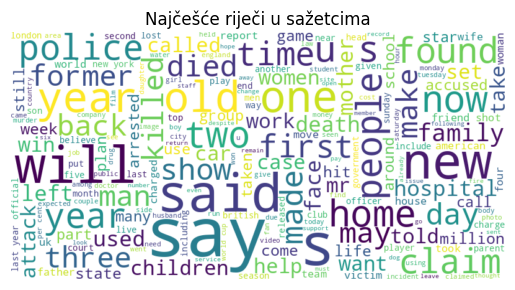

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud_summaries = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(' '.join(clean_summaries))


plt.imshow(wordcloud_summaries, interpolation='bilinear')
plt.title('Najčešće riječi u sažetcima')
plt.axis('off')
plt.savefig('wordcloud_summaries.png', bbox_inches='tight')

plt.show()


In [11]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_article[:11000]
clean_df['summary'] = clean_summaries[:11000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')


# Tokenizacija i sumarizacija

In [12]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)

In [13]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
freq = 0
total_freq = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_freq += value
    if value < thresh:
        count += 1
        freq += value

In [14]:
print('Postotak rijetkih riječi u x: ',(count/total_count)*100.0)
t_max_features = total_count - count
print('Vokabular: ', t_max_features)

Postotak rijetkih riječi u x:  58.1434446861257
Vokabular:  44067


In [15]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [16]:
print('Postotak rijetkih riječi u y: ', (count/total_count)*100.0)
s_max_features = total_count-count
print('Vokabular: ', s_max_features)

Postotak rijetkih riječi u y:  76.66035813073228
Vokabular:  8016


In [17]:
maxlen_text = 800
maxlen_summ = 100

In [18]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [19]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

# Embedding

In [20]:
embeding_index = {}
embed_dim = 100
with open('/home/vrsa/Documents/NLP2/zadnja_nada/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [21]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [22]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

# Model 

In [23]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)

enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])


#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()



2024-01-11 00:29:33.373210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 00:29:33.473345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 00:29:33.473594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 800)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 800, 100)             4406700   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 256),                234496    ['embedding[0][0]']           
 al)                          (None, 128),                                                    

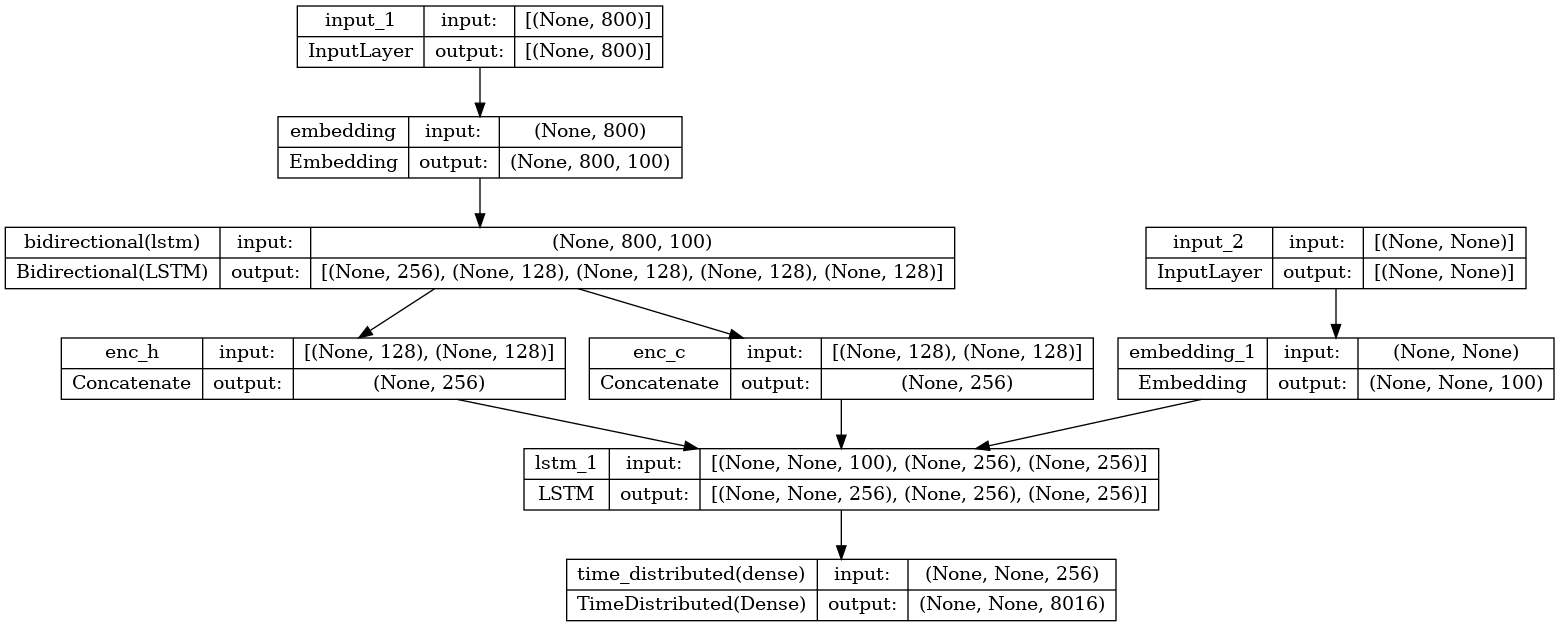

In [24]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'model_strukutura.png' ,show_shapes=True, show_layer_names=True)

In [25]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=100, callbacks=[early_stop], batch_size=32, verbose=1, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/100


2024-01-11 00:29:37.375237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-11 00:29:38.544510: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9ad9074d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 00:29:38.544542: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-01-11 00:29:38.552591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704929378.607446    5340 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


310/310 [==============================] - 64s 193ms/step - loss: 3.4465 - val_loss: 3.1423
Epoch 2/100
310/310 [==============================] - 58s 188ms/step - loss: 3.1509 - val_loss: 3.0356
Epoch 3/100
310/310 [==============================] - 59s 191ms/step - loss: 3.0701 - val_loss: 2.9721
Epoch 4/100
310/310 [==============================] - 60s 194ms/step - loss: 3.0089 - val_loss: 2.9177
Epoch 5/100
310/310 [==============================] - 59s 190ms/step - loss: 2.9604 - val_loss: 2.8766
Epoch 6/100
310/310 [==============================] - 60s 192ms/step - loss: 2.9202 - val_loss: 2.8451
Epoch 7/100
310/310 [==============================] - 58s 189ms/step - loss: 2.8861 - val_loss: 2.8157
Epoch 8/100
310/310 [==============================] - 58s 186ms/step - loss: 2.8568 - val_loss: 2.7943
Epoch 9/100
310/310 [==============================] - 59s 190ms/step - loss: 2.8301 - val_loss: 2.7723
Epoch 10/100
310/310 [==============================] - 63s 202ms/step - los

In [26]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [27]:
import pickle

enc_model.save('./encoder_model_100_epoha.h5')

dec_model.save('./decoder_model_100_epoha.h5')

with open('./s_tokenizer.pkl', 'wb') as f:
    pickle.dump(s_tokenizer, f)


/home/vrsa/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
def sumary(text):

    #with open('./s_tokenizer.pkl', 'rb') as f:
    #    s_tokenizer = pickle.load(f)

    #enc_model = tf.keras.models.load_model('./encoder_model_50_epoha.h5')
    #dec_model = tf.keras.models.load_model('./decoder_model_50_epoha.h5')

    #text = s_tokenizer.texts_to_sequences([input_text])
    #text = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=800, padding='post')

    h, c = enc_model.predict(text)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq

In [29]:
test_inputs = [clean_text(sent) for sent in test_data.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')


In [30]:
ulazni_clanci = test_inputs[:50]

In [32]:
sazetci = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['clanak', 'sazetak', 'm_sazetak'])
    for i in range(100):
        our_summ = sumary(test_inputs[i].reshape(1, maxlen_text))
        sazetci.append(our_summ)
        writer.writerow([test_data.article[i], test_data.highlights[i], our_summ])

1/1 [==============================] - 0s 14ms/step


In [33]:
data = pd.read_csv('./result.csv')

In [34]:
print(data)

                                               clanak  \
0   Ever noticed how plane seats appear to be gett...   
1   A drunk teenage boy had to be rescued by secur...   
2   Dougie Freedman is on the verge of agreeing a ...   
3   Liverpool target Neto is also wanted by PSG an...   
4   Bruce Jenner will break his silence in a two-h...   
..                                                ...   
95  As Zlatan Ibrahimovic famously believes the Wo...   
96  Jameela spent £3,000 on having all her amalgam...   
97  A paramedic who pretended he was gay to get cl...   
98  Paris Saint-Germain face Nice on Saturday, hop...   
99  (CNN)You know the phrase "dodging a bullet"? F...   

                                              sazetak  \
0   Experts question if  packed out planes are put...   
1   Drunk teenage boy climbed into lion enclosure ...   
2   Nottingham Forest are close to extending Dougi...   
3   Fiorentina goalkeeper Neto has been linked wit...   
4   Tell-all interview with th

In [35]:
broj_clanka = 3

print(data['clanak'][broj_clanka])
print("###########")
print(data['sazetak'][broj_clanka])
print("###########")
print(data['m_sazetak'][broj_clanka])

Liverpool target Neto is also wanted by PSG and clubs in Spain as Brendan Rodgers faces stiff competition to land the Fiorentina goalkeeper, according to the Brazilian's agent Stefano Castagna. The Reds were linked with a move for the 25-year-old, whose contract expires in June, earlier in the season when Simon Mignolet was dropped from the side. A January move for Neto never materialised but the former Atletico Paranaense keeper looks certain to leave the Florence-based club in the summer. Neto rushes from his goal as Juan Iturbe bears down on him during Fiorentina's clash with Roma in March . Neto is wanted by a number of top European clubs including Liverpool and PSG, according to his agent . It had been reported that Neto had a verbal agreement to join Serie A champions Juventus at the end of the season but his agent has revealed no decision about his future has been made yet. And Castagna claims Neto will have his pick of top European clubs when the transfer window re-opens in the

In [36]:
import tensorflow as tf
import numpy as np
import pickle

def load_Generate_summary(input_text):
    with open('./s_tokenizer.pkl', 'rb') as f:
        s_tokenizer = pickle.load(f)
    
    enc_model = tf.keras.models.load_model('./encoder_model_100_epoha.h5')
    dec_model = tf.keras.models.load_model('./decoder_model_100_epoha.h5')
    
    input_seq = s_tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=800, padding='post')
    
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq.strip()

In [37]:
text = "Egypt has one of the longest histories of any country, tracing its heritage along the Nile Delta back to the 6th–4th millennia BCE. Considered a cradle of civilisation, Ancient Egypt saw some of the earliest developments of writing, agriculture, urbanisation, organised religion and central government.[14] Iconic monuments such as the Giza Necropolis and its Great Sphinx, as well the ruins of Memphis, Thebes, Karnak, and the Valley of the Kings, reflect this legacy and remain a significant focus of scientific and popular interest. Egypt's long and rich cultural heritage is an integral part of its national identity, which reflects its unique transcontinental location being simultaneously Mediterranean, Middle Eastern and North African.[15] Egypt was an early and important centre of Christianity, but was largely Islamised in the seventh century and remains a predominantly Sunni Muslim country, albeit with a significant Christian minority, along with other lesser practiced faiths."
#text = " Reports of Cristiano Ronaldo's decline have been greatly exaggerated: The Real Madrid forward scored five goals against Granada, taking his tally in La Liga to 36 for the season - more than half of Europe's top teams. Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 at the Bernabeu, and their Portuguese talisman managed the first five-goal haul of his career. His record of 36 league goals for the season overtook Lionel Messi's 32 strikes, and put him in the incredible position of having scored more goals than 53 of the 98 teams in Europe's top five leagues this season. Cristiano Ronaldo scored an incredible five goals against Granada to lift his tally for the season to 36 . Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 . The Portuguese star now has more goals than 53 teams in Europe's top leagues, including nine in England . There are nine teams in the Barclays Premier League who have managed fewer goals in the league than Cristiano Ronaldo has this season. They are: . Stoke City, Newcastle United, West Bromwich Albion, Hull City, Aston Villa, Sunderland, Queens Park Rangers, Burnley and Leicester City. Ronaldo took some flak last month after a series of poor performances for Real, but his goalscoring has never waivered and even through a difficult period he managed six goals in 10 games, the sort of record most strikers can only dream of. And his displays across the season have brought more goals than the likes of Newcastle United, Malaga, Borussia Dortmund, Torino and Lille. The first three of his five goals against Granada marked the quickest hat-trick of his career, coming in just eight first half minutes. Another followed 16 minutes later, and his last came 35 minutes after that. Ronaldo's displays across the season have brought more goals than the likes of Borussia Dortmund and Lille . It all adds up to a brilliant Easter Sunday for the world's best player, and he spoke of his delight afterwards . Lionel Messi and Barcelona came out on top in El Clasico but he has fewer league goals than Ronaldo . Borussia Dortmund, who can boast Marco Reus among their ranks, have fewer goals than the Real talisman . While Ronaldo overtook Messi on the goalscoring charts, the hat-trick - which could have been doubled - levelled the Argentine's record of 24 La Liga trebles. He almost matched Real legend Alfredo Di Stefano's 28 hat-tricks for Los Blancos in what was their biggest league win in 48-and-a-half years. It all adds up to a brilliant Easter Sunday for the world's best player, and he posted on Twitter after the game, saying: 'Happy to have scored 5 goals with this excellent team work. Thank you for all your support.' If the critics still see Ronaldo as greedy, it certainly paid off at the Santiago Bernabeu on Sunday. Premier League: Stoke City, Newcastle United, West Bromwich Albion, Hull City, Aston Villa, Sunderland, Queens Park Rangers, Burnley, Leicester City. La Liga: Malaga, Athletic Bilbao, Rayo Vallecano, Real Sociedad, Celta Vigo, Espanyol, Getafe, Levante, Eibar, Elche, Deportivo la Coruna, Almeria, Granada, Cordoba. Bundesliga: Augsburg, Borussia Dortmund, Mainz, Cologne, Hertha Berlin, Freiberg, Hannover, Hamburg, Paderborn, Stuttgart. Serie A: Torino, Sassuolo, Udinese, Empoli, Chievo, Atalanta, Cesena, Cagliari, Parma. Ligue 1: Lille, Rennes, Nantes, Guingamp, Nice, Bastia, Evian, Lorient, Toulouse, Metz, Lens."
text = clean_text(text)
print(text)

sazetak= load_Generate_summary(text)




egypt one longest histories country tracing heritage along nile delta back 6th–4th millennia bce considered cradle civilisation ancient egypt saw earliest developments writing agriculture urbanisation organised religion central government 14 iconic monuments giza necropolis great sphinx well ruins memphis thebes karnak valley kings reflect legacy remain significant focus scientific popular interest egypt long rich cultural heritage integral part national identity reflects unique transcontinental location simultaneously mediterranean middle eastern north african 15 egypt early important centre christianity largely islamised seventh century remains predominantly sunni muslim country albeit significant christian minority along lesser practiced faiths


1/1 [==============================] - 0s 14ms/step


In [38]:
sazetak

'the of the of the top of the first time was a of the first time of the time of the time of the time of the time of the time the the time of the time was a in the first time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time'

In [39]:
file_path = "index_zivot_na_vagi_eng.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    index_text = file.read()
  


index_text = clean_text(index_text)

sazetak= load_Generate_summary(index_text)



1/1 [==============================] - 0s 13ms/step


In [40]:
print(index_text)
print(sazetak)

winner life scales mislav šepić index magazine 22 26 ​​january 4 2024 winner life scales mislav šepić 10 photo press studio jadran film zagreb direction marijana batinić contestants seventh season life scales showed full glory hard work commitment past five months paid first non finalists fought prize 7 500 euros showed results finalists fight 20 000 euros nina silvija mislav šepić goran secret finalist mislav vlašić took stage way accompanied coaches faithful support support mirna čužić edo mehmedović hide pride happiness saw contestants seventh season anđela akrap unfortunately could come due family obligations well krunoslav šuvak busy work ad first eliminated show continued practice outside returned show marsela karamatić 28 told goes gym watches diet want give irena changed habits irena pušec 48 also came completely changed habits leaves house every day sea family leonardo prajo 25 admitted difficult start cooking left ljube bartulović 33 said difficult come second time struggle c

In [41]:
file_path = "index_zivot_na_vagi_hrv.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    index_text_hr = file.read()
  


index_text_hr = clean_text(index_text_hr)

sazetak= load_Generate_summary(index_text_hr)



1/1 [==============================] - 0s 15ms/step


In [42]:
print(index_text_hr)
print(sazetak)

pobjednik života na vagi je mislav šepić index magazin 22 26 04 siječnja 2024 pobjednik života na vagi je mislav šepić 10 foto press u studiju zagrebačkog jadran filma pod voditeljskom palicom marijane batinić natjecatelji sedme sezone života na vagi pokazali su u punom sjaju da su se isplatili njihovi trud zalaganje u proteklih pet mjeseci prvo su svoje rezultate pokazali nefinalisti koji su se borili za nagradu od 7500 eura potom su na scenu stupiti finalisti u borbi za 20 000 eura nina silvija mislav šepić goran tajni finalist mislav vlašić na njihovu putu pratili su ih njihovi treneri vjerna podrška oslonac mirna čužić edo mehmedović koji nisu skrivali ponos sreću kad su ugledali natjecatelje sedme sezone anđela akrap nažalost nije mogla doći zbog obiteljskih obveza kao krunoslav šuvak koji je bio zauzet poslom ad prva je ispala iz showa nastavila vježbati vani potom se opet vratila u show marsela karamatić 28 ispričala je kako ide u teretanu pazi na prehranu ne želi odustati od to

In [46]:
rouge = Rouge()
rouge.get_scores(sazetci, test_data.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.07504621897300937,
  'p': 0.2863978917501935,
  'f': 0.11487240475869945},
 'rouge-2': {'r': 0.010585595974156512,
  'p': 0.036876256368903425,
  'f': 0.015926579306275095},
 'rouge-l': {'r': 0.0710412237015973,
  'p': 0.2726338600302794,
  'f': 0.1088780914505498}}